In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
import pickle
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import pandas as pd

In [2]:
import gfun_63 as gfun_63

# function = gfun_63.gfun_63  #assigning ground truth sim

#4: The Himmelblau Function
#ref. (HMCMC High Dim, Prof. Kostas)
# 2 independent standard normal random variables
def example_4 (x):
    beta = 95   # (beta = 95 for Ref. PF=1.65E-4)   (beta = 50 for Ref. PF=2.77E-7)
    term1 = (((0.75*x[:,0] - 0.5)**2 / 1.81) + ((0.75*x[:,1] - 0.5) / 1.81) - 11)**2
    term2 = (((0.75*x[:,0] - 1.0)/ 1.81) + ((0.75*x[:,1] - 0.5)**2 / 1.81) - 7)**2
    g = term1 + term2 - beta
    return g

function = example_4

In [3]:
dim = 2
n_mcs = int(1e6)
Xtest = np.random.normal(0.0, 1.0, size=(n_mcs, dim))
y_test = function(Xtest)

Pf_ref = np.sum( y_test < 0 ) / n_mcs
B_ref= - norm.ppf( Pf_ref )
Pf_ref, B_ref

(0.000159, 3.6001775200484394)

In [8]:
# Loading final pf results for all experiments

number_experiments = 5
initial_doe = 10
active_points = 50
surrogate_type = 'PCK_'  # 'GP_' or 'PCK_'

PF_evol = np.zeros ((active_points, number_experiments))

for Batch in range (0, number_experiments):
    
    file_name = surrogate_type +'Batch_' + str(Batch+1) +'.sav'

    experiment = pickle.load(open(file_name, 'rb'))
    
    for points in range (0, active_points):
        
        training_p = initial_doe + points+1

        PF_evol[points, Batch] = experiment[surrogate_type + str(training_p)][0]

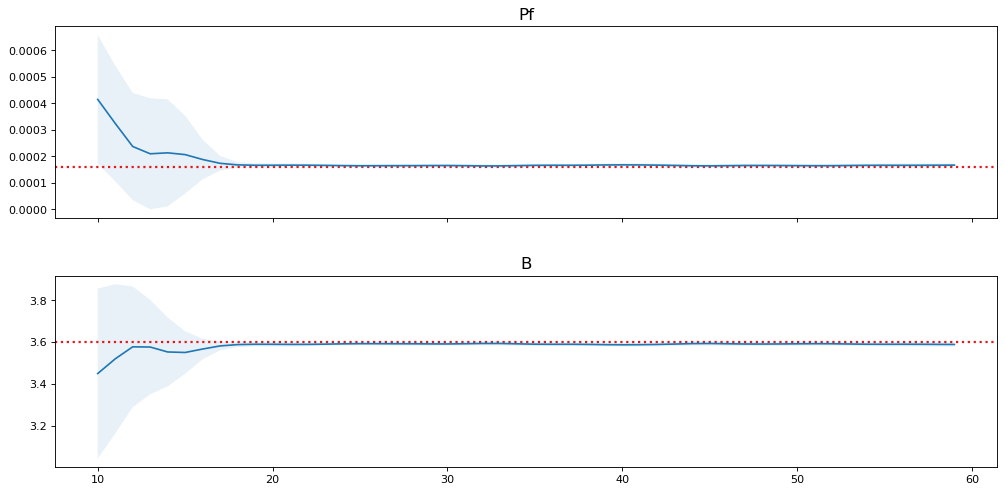

In [9]:
cm = 2 /2.54  # centimeters in inches
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 12

fig3, axs = plt.subplots(2,1, figsize=(17*cm, 10*cm), sharex = 'col', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=0.98, top=0.92, bottom=0.22, hspace = 0.3, wspace=0.1)

training_points = [i for i in range(initial_doe, initial_doe+active_points)]

#------------------------------------ in case a limit state has any pf = 0 
penalization = 10e-7
ls_penal = 1

Pf_corr = pd.DataFrame(PF_evol)      #check colum with values to penalize
Pf_corr.replace([0], (penalization), inplace=True)
B_evol_CORR = - norm.ppf(Pf_corr)

axs[0].axhline(y = Pf_ref, color = '#e31a1c', linestyle = ':', lw=2.0)
axs[0].set_title('Pf', fontsize = 15)

axs[1].axhline(y = B_ref, color = '#e31a1c', linestyle = ':', lw=2.0)
axs[1].set_title('B', fontsize = 15)

#PF EVOLUTION -------------------------------------------------
# for points in range(active_points):
sigma_std = 1.5

mean_pf1 = np.median(PF_evol , axis=1)
std_pf1 = np.std(PF_evol, axis=1)
CI_pf1 = 1.96 * (std_pf1 / np.sqrt(number_experiments)) 
axs[0].plot(training_points, gaussian_filter1d(mean_pf1, sigma=sigma_std))
axs[0].fill_between(training_points, gaussian_filter1d(mean_pf1 + CI_pf1, sigma=sigma_std), gaussian_filter1d(mean_pf1 - CI_pf1, sigma=sigma_std), alpha=0.1)

mean_b1 = np.median(B_evol_CORR , axis=1)
std_b1 = np.std(B_evol_CORR, axis=1)
CI_b1 = 1.96 * (std_b1 / np.sqrt(number_experiments)) 
axs[1].plot(training_points, gaussian_filter1d(mean_b1, sigma=sigma_std))
axs[1].fill_between(training_points, gaussian_filter1d(mean_b1 + CI_b1, sigma=sigma_std), gaussian_filter1d(mean_b1 - CI_b1, sigma=sigma_std), alpha=0.1)